In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
import warnings
warnings.filterwarnings("ignore")

In [11]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
            'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
            'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
            'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
            'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
            'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
            'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']

train_set = pd.read_csv('KDDTrain+.txt', sep = ",", header = None)
test_set = pd.read_csv('KDDTest+.txt', sep = ",", header = None)

train_set = train_set.iloc[:, :-1]
test_set = test_set.iloc[:, :-1]

train_set.columns = col_names
test_set.columns = col_names

print(f'training set dim: {train_set.shape}')
print(f'test set dim: {test_set.shape}')

training set dim: (125973, 42)
test set dim: (22544, 42)


In [12]:
train_set.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [13]:
test_set.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [14]:
#label distribution of Training set and testing set
print('Label distribution Training set:')
print(train_set['class'].value_counts())
print()
print('Label distribution Test set:')
print(test_set['class'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: class, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


In [16]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in train_set.columns:
    if train_set[col_name].dtypes == 'object' :
        unique_cat = len(train_set[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(train_set['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'class' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [17]:
# Test set
print('Test set:')
for col_name in test_set.columns:
    if test_set[col_name].dtypes == 'object' :
        unique_cat = len(test_set[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'class' has 38 categories


In [20]:
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
train_set_categorical_values = train_set[categorical_columns]
test_set_categorical_values = train_set[categorical_columns]

In [21]:
train_set_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [22]:
# protocol type
unique_protocol=sorted(train_set.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(train_set.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(train_set.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(train_set.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [25]:
#Transform categorical features into numbers using LabelEncoder()
train_set_categorical_values_enc=train_set_categorical_values.apply(LabelEncoder().fit_transform)
print(train_set_categorical_values_enc.head())
# test set
test_set_categorical_values_enc=test_set_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [26]:
#One-Hot-Encoding¶
enc = OneHotEncoder()
train_set_categorical_values_encenc = enc.fit_transform(train_set_categorical_values_enc)
train_set_cat_data = pd.DataFrame(train_set_categorical_values_encenc.toarray(),columns=dumcols)
# test set
test_set_categorical_values_encenc = enc.fit_transform(test_set_categorical_values_enc)
test_set_cat_data = pd.DataFrame(test_set_categorical_values_encenc.toarray(),columns=testdumcols)

In [27]:
train_set_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
trainservice=train_set['service'].tolist()
testservice= test_set['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_aol',
 'service_red_i',
 'service_urh_i',
 'service_harvest',
 'service_http_2784',
 'service_http_8001']

In [29]:
for col in difference:
    test_set_cat_data[col] = 0

test_set_cat_data.shape

(125973, 84)

In [30]:
#Join encoded categorical dataframe with the non-categorical dataframe
newdf=train_set.join(train_set_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=test_set.join(test_set_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [44]:
# take label column
labeldf=newdf['class']
labeldf_test=newdf_test['class']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [45]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['class'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['class'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['class'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['class'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['class'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['class'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['class'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['class'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 124)
Dimensions of Probe: (78999, 124)
Dimensions of R2L: (68338, 124)
Dimensions of U2R: (67395, 124)
Test:
Dimensions of DoS: (17171, 124)
Dimensions of Probe: (12132, 124)
Dimensions of R2L: (12596, 124)
Dimensions of U2R: (9778, 124)


In [46]:
DoS_df


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [52]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

In [48]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [53]:
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

In [54]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1.]


In [56]:
X_Probe.std(axis=0)
X_R2L.std(axis=0)
X_U2R.std(axis=0)

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1.])

In [57]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

(113270, 13)

In [58]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [59]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

(78999, 13)

In [60]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [61]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

(68338, 13)

In [62]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'class',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [63]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

(67395, 13)

In [64]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

In [65]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_R2L)
print()
print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Features selected for Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Features selected for R2L: ['dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'class', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Features selected for U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same

In [66]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))



DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [67]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]


In [68]:

rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'class'), (2, 'flag_RSTO'), (3, 'service_imap4'), (4, 'service_http'), (5, 'service_ftp_data'), (6, 'service_ftp'), (7, 'dst_host_srv_diff_host_rate'), (8, 'dst_host_same_src_port_rate'), (9, 'dst_host_srv_count'), (10, 'is_guest_login'), (11, 'num_failed_logins'), (12, 'hot'), (13, 'dst_bytes')]


In [69]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'root_shell'), (5, 'num_shells'), (6, 'service_ftp_data'), (7, 'dst_host_srv_diff_host_rate'), (8, 'num_file_creations'), (9, 'dst_host_same_src_port_rate'), (10, 'service_telnet'), (11, 'srv_diff_host_rate'), (12, 'service_http'), (13, 'urgent')]


In [70]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)


In [71]:
rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [74]:
rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [72]:
rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

In [75]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)


Features selected for DoS: ['class', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH']

Features selected for Probe: ['class', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH']

Features selected for R2L: ['class', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH']

Features selected for U2R: ['class', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH']


In [76]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Classifier is trained for all features and for reduced features, for later comparison.


# The classifier model itself is stored in the clf variable.

In [77]:
# all features
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_R2L=DecisionTreeClassifier(random_state=0)
clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_U2R.fit(X_U2R, Y_U2R.astype(int))

DecisionTreeClassifier(random_state=0)

In [78]:
# selected features
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeR2L=DecisionTreeClassifier(random_state=0)
clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

DecisionTreeClassifier(random_state=0)

# 5. Prediction & Evaluation (validation):


# Using all Features for each category

# Confusion Matrices : DoS


In [79]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([1, 1, 0, ..., 0, 1, 0])

In [80]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [86]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9711,0
1,0,7460


# Confusion Matrices : Probe

In [87]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9711,0
2,0,2421


# Confusion Matrices : R2L

In [88]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


# Confusion Matrices : U2R

In [84]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS¶


In [85]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)


# Probe¶


In [89]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)


# R2L¶


In [90]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)


# U2R¶


In [91]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)


# RFECV for illustration¶


In [92]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

Automatically created module for IPython interactive environment


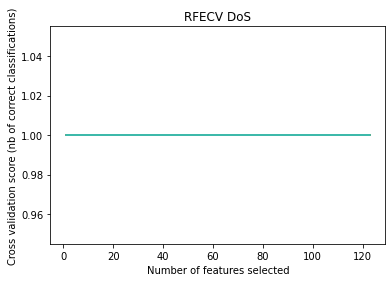

In [93]:
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

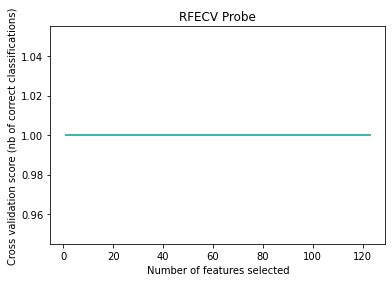

In [94]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

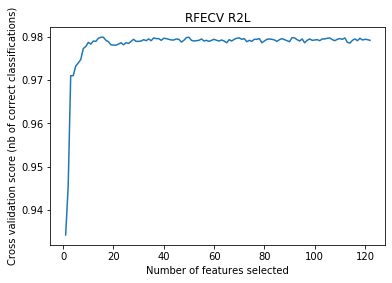

In [ ]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

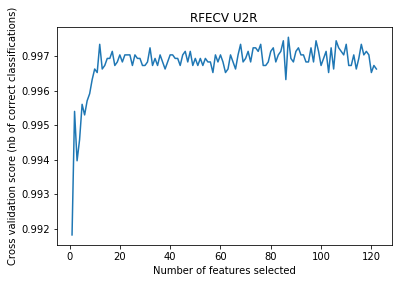

In [ ]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
clf1 = RandomForestClassifier(n_jobs=2, random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf1, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))



DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'dst_host_srv_serror_rate'), (3, 'flag_SF'), (4, 'count'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_serror_rate'), (8, 'logged_in'), (9, 'dst_host_count'), (10, 'srv_serror_rate'), (11, 'service_http'), (12, 'serror_rate'), (13, 'flag_S0')]


In [ ]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_diff_srv_rate'), (3, 'service_private'), (4, 'service_eco_i'), (5, 'dst_host_srv_count'), (6, 'dst_host_srv_diff_host_rate'), (7, 'dst_host_rerror_rate'), (8, 'dst_host_srv_rerror_rate'), (9, 'logged_in'), (10, 'rerror_rate'), (11, 'srv_rerror_rate'), (12, 'Protocol_type_icmp'), (13, 'flag_SF')]


In [ ]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'hot'), (3, 'dst_host_same_src_port_rate'), (4, 'service_ftp_data'), (5, 'dst_host_srv_diff_host_rate'), (6, 'dst_host_srv_count'), (7, 'service_ftp'), (8, 'dst_bytes'), (9, 'service_http'), (10, 'num_failed_logins'), (11, 'is_guest_login'), (12, 'flag_RSTO'), (13, 'service_imap4')]


In [ ]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'num_file_creations'), (2, 'dst_host_count'), (3, 'dst_host_srv_count'), (4, 'hot'), (5, 'root_shell'), (6, 'dst_host_srv_diff_host_rate'), (7, 'dst_host_same_src_port_rate'), (8, 'service_ftp_data'), (9, 'num_shells'), (10, 'service_telnet'), (11, 'urgent'), (12, 'service_http'), (13, 'srv_diff_host_rate')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)¶

In [ ]:
from sklearn.feature_selection import RFE
clf1 = RandomForestClassifier(n_jobs=2, random_state=0)
rfe = RFE(estimator=clf1, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)


In [ ]:
rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [ ]:
rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [ ]:
rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of Features selected by RFE

In [ ]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)


Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'Protocol_type_icmp', 'Protocol_type_tcp', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_eco_i', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'service_ftp', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'dst_host_count', 'ds

In [ ]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Build RF model

# Classifier is trained for all features and for reduced features, for later comparison.

# The classifier model itself is stored in the clf variable.

In [ ]:
# all features
clf1_DoS=RandomForestClassifier(random_state=0)
clf1_Probe=RandomForestClassifier(random_state=0)
clf1_R2L=RandomForestClassifier(random_state=0)
clf1_U2R=RandomForestClassifier(random_state=0)
clf1_DoS.fit(X_DoS, Y_DoS.astype(int))
clf1_Probe.fit(X_Probe, Y_Probe.astype(int))
clf1_R2L.fit(X_R2L, Y_R2L.astype(int))
clf1_U2R.fit(X_U2R, Y_U2R.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# selected features
clf1_rfeDoS=RandomForestClassifier(random_state=0)
clf1_rfeProbe=RandomForestClassifier(random_state=0)
clf1_rfeR2L=RandomForestClassifier(random_state=0)
clf1_rfeU2R=RandomForestClassifier(random_state=0)
clf1_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf1_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf1_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf1_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Evaluation and Predictions

# Confusion Matrices : DoS


In [ ]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf1_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# View the predicted probabilities of the first 10 observations
clf1_DoS.predict_proba(X_DoS_test)[0:10]

array([[0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.5, 0.5],
       [0.8, 0.2]])

In [ ]:
Y_DoS_pred=clf1_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9188,523
1,6901,559


# Confusion Matrices : Probe


In [ ]:
Y_Probe_pred=clf1_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9522,189
2,1256,1165


# Confusion Matrices : R2L

In [ ]:
Y_R2L_pred=clf1_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9711,0
3,2884,1


# Confusion Matrices : U2R

In [ ]:
Y_U2R_pred=clf1_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS¶

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99819 (+/- 0.00211)
Precision: 0.99919 (+/- 0.00132)
Recall: 0.99665 (+/- 0.00468)
F-measure: 0.99792 (+/- 0.00244)


# Probe

In [ ]:
accuracy = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99613 (+/- 0.00295)
Precision: 0.99618 (+/- 0.00466)
Recall: 0.99169 (+/- 0.00595)
F-measure: 0.99391 (+/- 0.00465)


# R2L

In [ ]:
accuracy = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.98039 (+/- 0.00775)
Precision: 0.97501 (+/- 0.00958)
Recall: 0.96926 (+/- 0.01519)
F-measure: 0.97205 (+/- 0.01121)


# U2R

In [ ]:
accuracy = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.99703 (+/- 0.00250)
Precision: 0.94882 (+/- 0.12792)
Recall: 0.82826 (+/- 0.15928)
F-measure: 0.87118 (+/- 0.11935)


# RFECV for illustration¶

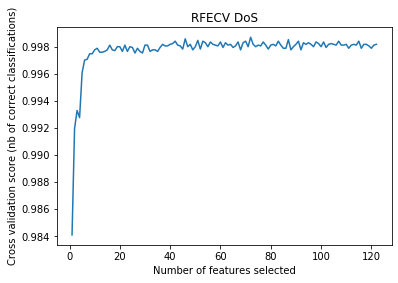

In [ ]:
rfecv_DoS = RFECV(estimator=clf1_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

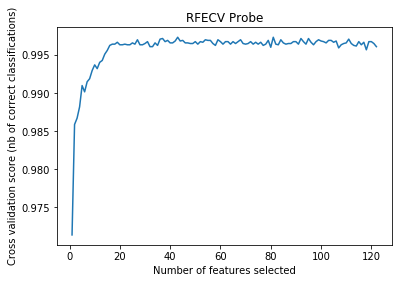

In [ ]:
rfecv_Probe = RFECV(estimator=clf1_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

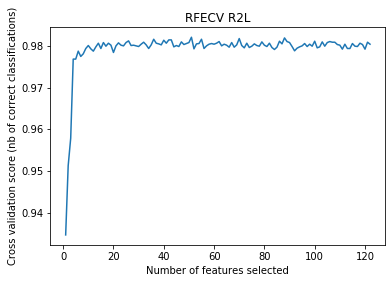

In [ ]:
rfecv_R2L = RFECV(estimator=clf1_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

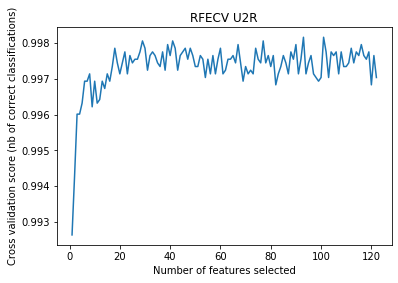

In [ ]:
rfecv_U2R = RFECV(estimator=clf1_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.
#2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)¶

# Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
clf2 =GaussianNB()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf2, n_features_to_select=13)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'count'), (1, 'dst_host_count'), (1, 'dst_host_same_srv_rate'), (1, 'dst_host_serror_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_serror_rate'), (1, 'flag_S0'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'same_srv_rate'), (1, 'serror_rate'), (1, 'service_http'), (1, 'srv_serror_rate')]


In [ ]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'Protocol_type_icmp'), (1, 'dst_host_diff_srv_rate'), (1, 'dst_host_rerror_rate'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'dst_host_srv_rerror_rate'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'rerror_rate'), (1, 'service_eco_i'), (1, 'service_private'), (1, 'srv_rerror_rate')]


In [ ]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'dst_bytes'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'flag_RSTO'), (1, 'hot'), (1, 'is_guest_login'), (1, 'num_failed_logins'), (1, 'service_ftp'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_imap4'), (1, 'src_bytes')]


In [ ]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'dst_host_count'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'hot'), (1, 'num_file_creations'), (1, 'num_shells'), (1, 'root_shell'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_telnet'), (1, 'srv_diff_host_rate'), (1, 'urgent')]


# Building the Naive Bayes Model

In [ ]:
# all features
clf2_DoS=GaussianNB()
clf2_Probe=GaussianNB()
clf2_R2L=GaussianNB()
clf2_U2R=GaussianNB()
clf2_DoS.fit(X_DoS, Y_DoS.astype(int))
clf2_Probe.fit(X_Probe, Y_Probe.astype(int))
clf2_R2L.fit(X_R2L, Y_R2L.astype(int))
clf2_U2R.fit(X_U2R, Y_U2R.astype(int))

GaussianNB(priors=None, var_smoothing=1e-09)

# Evaluation and Predictions

# Confusion Matrices : DoS

In [ ]:
clf2_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# View the predicted probabilities of the first 10 observations
clf2_DoS.predict_proba(X_DoS_test)[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [ ]:
Y_DoS_pred=clf2_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9447,264
1,3701,3759


# Confusion Matrices : Probe

In [ ]:
Y_Probe_pred=clf2_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,76,9635
2,201,2220


# Confusion Matrices : R2L

In [ ]:
Y_R2L_pred=clf2_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


# Confusion Matrices : U2R

In [ ]:
Y_U2R_pred=clf2_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.86733 (+/- 0.01474)
Precision: 0.98822 (+/- 0.01158)
Recall: 0.70308 (+/- 0.03682)
F-measure: 0.82145 (+/- 0.02371)


# Probe

In [ ]:
accuracy = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97898 (+/- 0.01148)
Precision: 0.97323 (+/- 0.00912)
Recall: 0.96051 (+/- 0.03039)
F-measure: 0.96654 (+/- 0.01926)


# R2L

In [ ]:
accuracy = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.93561 (+/- 0.01004)
Precision: 0.89097 (+/- 0.01370)
Recall: 0.95508 (+/- 0.00770)
F-measure: 0.91620 (+/- 0.01202)


# U2R

In [ ]:
accuracy = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.97259 (+/- 0.01121)
Precision: 0.60132 (+/- 0.02891)
Recall: 0.97911 (+/- 0.04265)
F-measure: 0.66067 (+/- 0.04235)


# KNeighbour Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
clf3 = KNeighborsClassifier()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf3, n_features_to_select=13)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'count'), (1, 'dst_host_count'), (1, 'dst_host_same_srv_rate'), (1, 'dst_host_serror_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_serror_rate'), (1, 'flag_S0'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'same_srv_rate'), (1, 'serror_rate'), (1, 'service_http'), (1, 'srv_serror_rate')]


In [ ]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'Protocol_type_icmp'), (1, 'dst_host_diff_srv_rate'), (1, 'dst_host_rerror_rate'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'dst_host_srv_rerror_rate'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'rerror_rate'), (1, 'service_eco_i'), (1, 'service_private'), (1, 'srv_rerror_rate')]


In [ ]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'dst_bytes'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'flag_RSTO'), (1, 'hot'), (1, 'is_guest_login'), (1, 'num_failed_logins'), (1, 'service_ftp'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_imap4'), (1, 'src_bytes')]


In [ ]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'dst_host_count'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'hot'), (1, 'num_file_creations'), (1, 'num_shells'), (1, 'root_shell'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_telnet'), (1, 'srv_diff_host_rate'), (1, 'urgent')]


# Building the KNearistNeighbour Classifier

In [ ]:
# all features
clf3_DoS=KNeighborsClassifier()
clf3_Probe=KNeighborsClassifier()
clf3_R2L=KNeighborsClassifier()
clf3_U2R=KNeighborsClassifier()
clf3_DoS.fit(X_DoS, Y_DoS.astype(int))
clf3_Probe.fit(X_Probe, Y_Probe.astype(int))
clf3_R2L.fit(X_R2L, Y_R2L.astype(int))
clf3_U2R.fit(X_U2R, Y_U2R.astype(int))

# Evaluation and Predictions

In [ ]:
# Confusion Matrices : DoS

In [ ]:
clf3_DoS.predict(X_DoS_test)

In [ ]:
# View the predicted probabilities of the first 10 observations
clf3_DoS.predict_proba(X_DoS_test)[0:10]

In [ ]:
Y_DoS_pred=clf3_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : Probe

In [ ]:
Y_Probe_pred=clf3_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : R2L

In [ ]:
Y_R2L_pred=clf3_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : U2R

In [ ]:
Y_U2R_pred=clf3_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# Probe

In [ ]:
accuracy = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# R2L

In [ ]:
accuracy = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# U2R